In [9]:
pip install torch scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 79.2 MB/s  0:00:00 83.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

✅ Successfully loaded data!
   Rows (Envs): 40960
   Columns:     4849
✅ Fixed 'gt_fric_force' column types.

--- Target Property Distributions ---


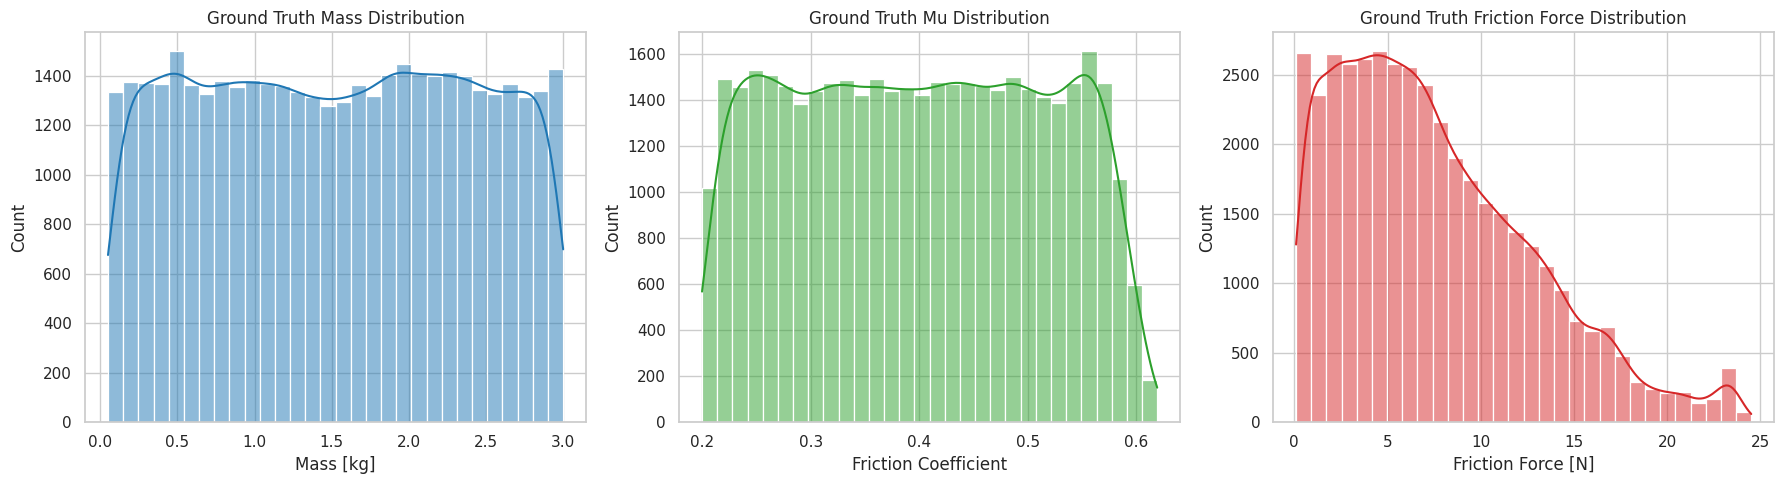


ANALYZING SAMPLE #30718
GT Mass: 2.908 kg
GT Mu:   0.325
GT Fric Force (Target): 10.751 N
Time Window: 63 -> 83


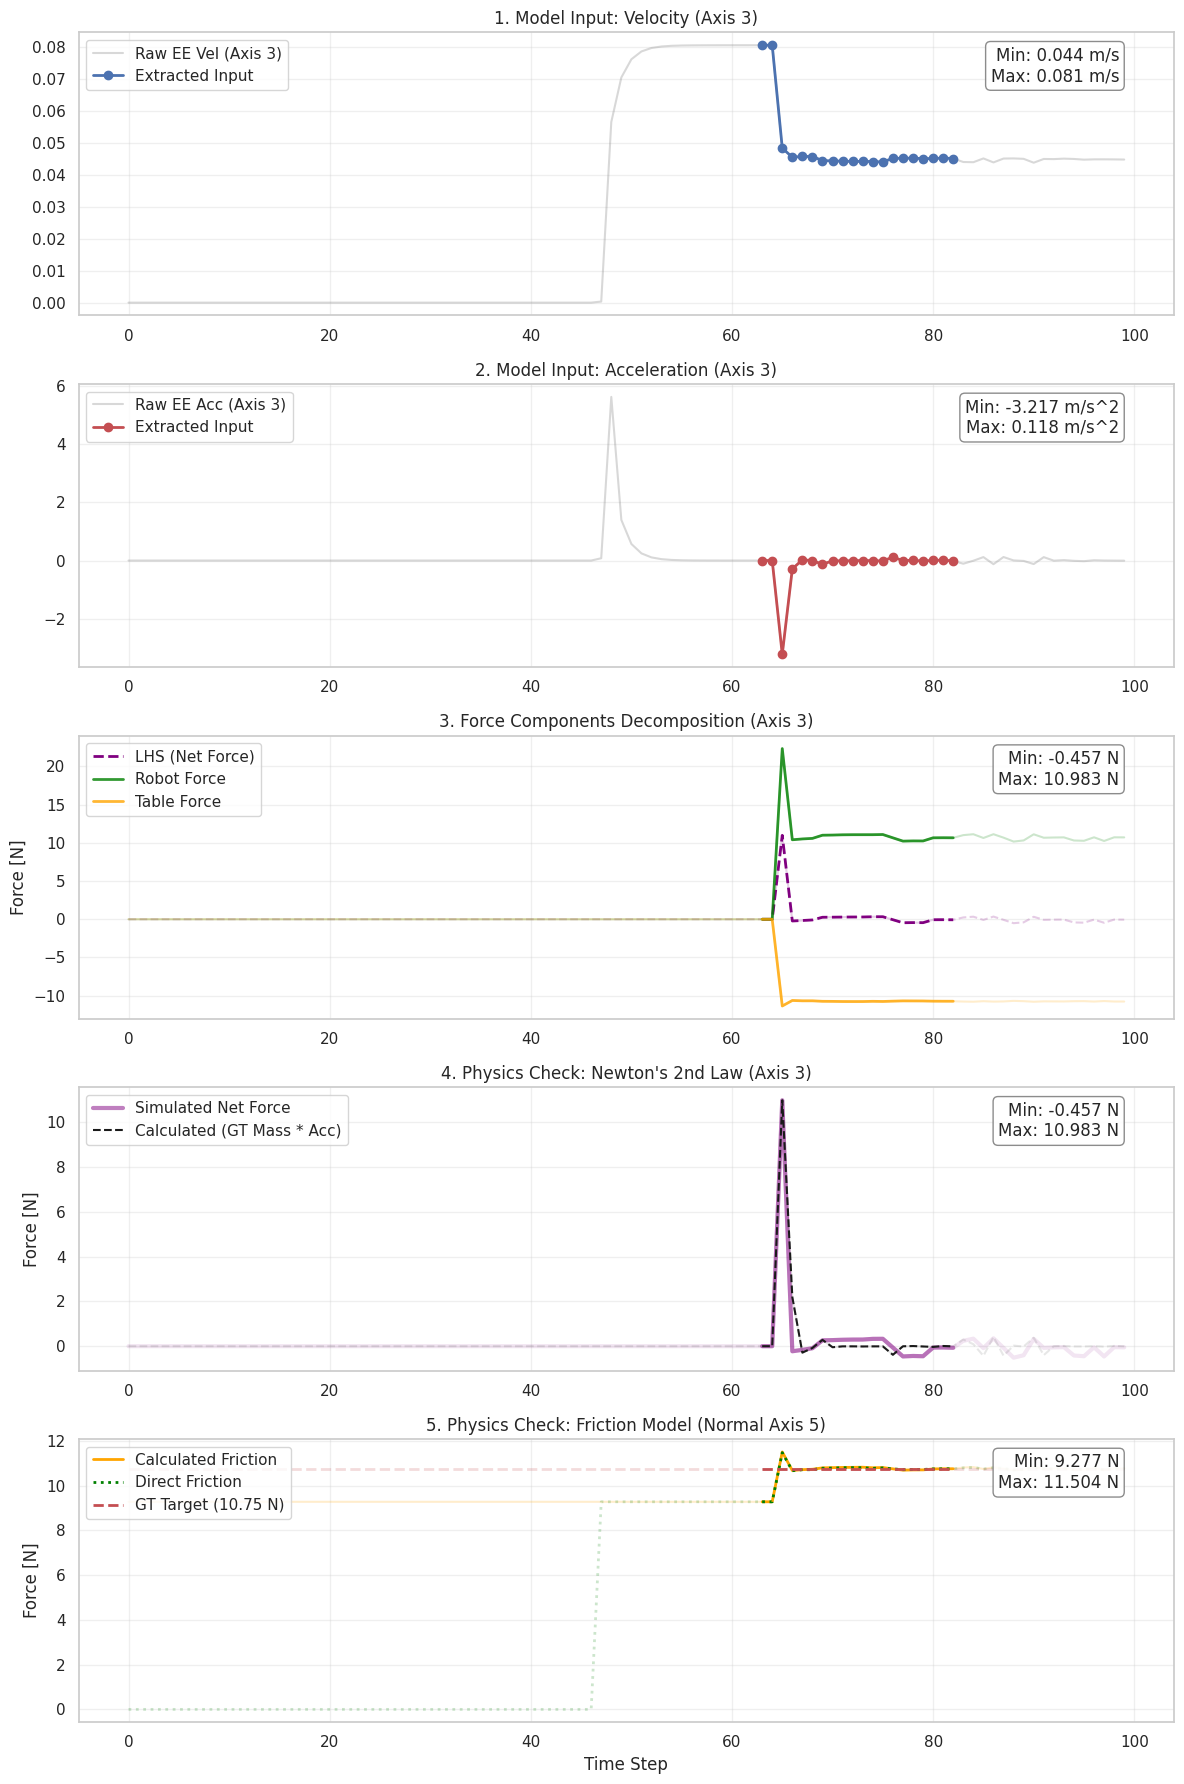

In [51]:

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_PATH = "/home/psxkf4/IsaacLab/source/collected_data/offline_data_8192.csv" 

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ==========================================
# 2. LOAD DATA
# ==========================================
if not os.path.exists(CSV_PATH):
    print(f"❌ Error: File not found at {CSV_PATH}")
    print("Please check the path and try again.")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Successfully loaded data!")
    print(f"   Rows (Envs): {df.shape[0]}")
    print(f"   Columns:     {df.shape[1]}")
    
    # Optional: Display the dataframe
    # display(df)

# --- FIX DATA TYPES ---
# The 'gt_fric_force' column might be saved as strings (e.g., "[4.23]"). 
def clean_force_col(x):
    if isinstance(x, str):
        return float(x.strip('[]'))
    return x

if 'gt_fric_force' in df.columns:
    df['gt_fric_force'] = df['gt_fric_force'].apply(clean_force_col)
    print("✅ Fixed 'gt_fric_force' column types.")

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def get_sequence_data(row, prefix, seq_len=100, num_axes=6):
    """Reconstructs (100, 6) array from flattened columns like 'prefix_t0_ax0'"""
    data = np.zeros((seq_len, num_axes))
    for t in range(seq_len):
        for ax in range(num_axes):
            col = f"{prefix}_t{t}_ax{ax}"
            if col in row:
                data[t, ax] = row[col]
    return data

def get_flat_window(row, prefix, window_size=10):
    """Reconstructs 1D array from columns like 'prefix_0', 'prefix_1'"""
    data = np.zeros(window_size)
    for i in range(window_size):
        col = f"{prefix}_{i}"
        if col in row:
            data[i] = row[col]
    return data

# ==========================================
# 4. DISTRIBUTION PLOTS (Targets)
# ==========================================
if 'df' in locals():
    print("\n--- Target Property Distributions ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Mass
    sns.histplot(df['gt_mass'], kde=True, ax=axes[0], color='tab:blue', bins=30)
    axes[0].set_title('Ground Truth Mass Distribution')
    axes[0].set_xlabel('Mass [kg]')
    
    # Friction Coeff
    sns.histplot(df['gt_mu'], kde=True, ax=axes[1], color='tab:green', bins=30)
    axes[1].set_title('Ground Truth Mu Distribution')
    axes[1].set_xlabel('Friction Coefficient')
    
    # Friction Force
    sns.histplot(df['gt_fric_force'], kde=True, ax=axes[2], color='tab:red', bins=30)
    axes[2].set_title('Ground Truth Friction Force Distribution')
    axes[2].set_xlabel('Friction Force [N]')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. INTEGRATED SAMPLE ANALYSIS (UPDATED WITH HIGHLIGHTS + MIN/MAX)
# ==========================================
if 'df' in locals():
    # --- CONFIGURATION ---
    AXIS_MOTION = 3   
    AXIS_VERTICAL = 5 
    G = 9.81

    # 1. Pick a single random sample for ALL plots
    sample_idx = np.random.randint(0, len(df))
    row = df.iloc[sample_idx]
    
    print(f"\n=======================================================")
    print(f"ANALYZING SAMPLE #{sample_idx}")
    print(f"=======================================================")
    print(f"GT Mass: {row['gt_mass']:.3f} kg")
    print(f"GT Mu:   {row['gt_mu']:.3f}")
    
    gt_fric_force_val = row['gt_fric_force']
    if isinstance(gt_fric_force_val, str):
        gt_fric_force_val = float(gt_fric_force_val.strip('[]'))
    print(f"GT Fric Force (Target): {gt_fric_force_val:.3f} N")
    print(f"Time Window: {int(row['start_t'])} -> {int(row['end_t'])}")

    # --- HELPER TO ADD MIN/MAX TEXT ---
    def add_min_max_text(ax, data, unit=""):
        dmin, dmax = np.min(data), np.max(data)
        stats_text = f"Min: {dmin:.3f} {unit}\nMax: {dmax:.3f} {unit}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                horizontalalignment='right', verticalalignment='top', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    # --- 2. EXTRACT DATA ---
    raw_acc = get_sequence_data(row, "raw_ee_acc")
    raw_vel = get_sequence_data(row, "raw_ee_vel")
    
    input_cols = [c for c in df.columns if "input_acc_" in c]
    win_len = len(input_cols)
    input_acc = get_flat_window(row, "input_acc", win_len)
    input_vel = get_flat_window(row, "input_vel", win_len)
    
    lhs_wrench = get_sequence_data(row, "pinn_LHS_wrench")      
    rhs_acc = get_sequence_data(row, "pinn_RHS_acc")            
    robot_wrench = get_sequence_data(row, "pinn_robot_wrench")  
    table_wrench = get_sequence_data(row, "pinn_table_wrench")  
    
    start_t = int(row['start_t'])
    time_steps = np.arange(start_t, start_t + win_len)

    # --- 3. CALCULATIONS ---
    # Newton Check
    net_force_sim = lhs_wrench[:, AXIS_MOTION]
    acc_sim = rhs_acc[:, AXIS_MOTION]
    net_force_calc = row['gt_mass'] * acc_sim

    # Friction Check
    robot_force_vertical = robot_wrench[:, AXIS_VERTICAL]
    normal_force_calc = (row['gt_mass'] * G) - robot_force_vertical
    fric_force_calc_profile = row['gt_mu'] * normal_force_calc
    
    normal_force_direct = table_wrench[:, AXIS_VERTICAL]
    fric_force_direct_profile = row['gt_mu'] * normal_force_direct
    
    fric_force_gt_line = np.full_like(fric_force_calc_profile, gt_fric_force_val)

    # --- 4. PLOTTING ---
    fig, axes = plt.subplots(5, 1, figsize=(12, 18))
    
    # Plot 1: Velocity Input
    axes[0].plot(raw_vel[:, AXIS_MOTION], label=f'Raw EE Vel (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[0].plot(time_steps, input_vel, 'b-o', linewidth=2, label='Extracted Input')
    
    axes[0].set_title(f"1. Model Input: Velocity (Axis {AXIS_MOTION})")
    add_min_max_text(axes[0], input_vel, "m/s") # Add stats
    axes[0].legend(loc='upper left')

    # Plot 2: Acceleration Input
    axes[1].plot(raw_acc[:, AXIS_MOTION], label=f'Raw EE Acc (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[1].plot(time_steps, input_acc, 'r-o', linewidth=2, label='Extracted Input')
    
    axes[1].set_title(f"2. Model Input: Acceleration (Axis {AXIS_MOTION})")
    add_min_max_text(axes[1], input_acc, "m/s^2") # Add stats
    axes[1].legend(loc='upper left')

    # Plot 3: Component Breakdown
    lhs_val = lhs_wrench[:, AXIS_MOTION]
    robot_val = robot_wrench[:, AXIS_MOTION]
    table_val = table_wrench[:, AXIS_MOTION]
    
    # Background
    axes[2].plot(lhs_val, color='purple', linestyle='--', alpha=0.2)
    axes[2].plot(robot_val, color='green', alpha=0.2)
    axes[2].plot(table_val, color='orange', alpha=0.2)
    
    # Foreground
    net_win = lhs_val[time_steps]
    axes[2].plot(time_steps, net_win, label='LHS (Net Force)', color='purple', linestyle='--', linewidth=2)
    axes[2].plot(time_steps, robot_val[time_steps], label='Robot Force', color='green', alpha=0.8, linewidth=2)
    axes[2].plot(time_steps, table_val[time_steps], label='Table Force', color='orange', alpha=0.8, linewidth=2)
    
    axes[2].set_title(f"3. Force Components Decomposition (Axis {AXIS_MOTION})")
    axes[2].set_ylabel("Force [N]")
    add_min_max_text(axes[2], net_win, "N") # Add stats for Net Force
    axes[2].legend(loc='upper left')

    # Plot 4: Newton's Law Check
    # Background
    axes[3].plot(net_force_sim, color='purple', linewidth=3, alpha=0.1)
    axes[3].plot(net_force_calc, 'k--', linewidth=1.5, alpha=0.1)
    
    # Foreground
    sim_win = net_force_sim[time_steps]
    axes[3].plot(time_steps, sim_win, label='Simulated Net Force', color='purple', linewidth=3, alpha=0.5)
    axes[3].plot(time_steps, net_force_calc[time_steps], 'k--', label='Calculated (GT Mass * Acc)', linewidth=1.5)
    
    axes[3].set_title(f"4. Physics Check: Newton's 2nd Law (Axis {AXIS_MOTION})")
    axes[3].set_ylabel("Force [N]")
    add_min_max_text(axes[3], sim_win, "N") # Add stats for Sim Force
    axes[3].legend(loc='upper left')

    # Plot 5: Friction Model Check
    # Background
    axes[4].plot(fric_force_calc_profile, color='orange', alpha=0.2)
    axes[4].plot(fric_force_direct_profile, color='green', linestyle=':', linewidth=2, alpha=0.2)
    axes[4].plot(fric_force_gt_line, 'r--', linewidth=2, alpha=0.2)

    # Foreground
    calc_win = fric_force_calc_profile[time_steps]
    axes[4].plot(time_steps, calc_win, label='Calculated Friction', color='orange', linewidth=2)
    axes[4].plot(time_steps, fric_force_direct_profile[time_steps], label='Direct Friction', color='green', linestyle=':', linewidth=2)
    axes[4].plot(time_steps, fric_force_gt_line[time_steps], 'r--', label=f'GT Target ({gt_fric_force_val:.2f} N)', linewidth=2)
    
    axes[4].set_title(f"5. Physics Check: Friction Model (Normal Axis {AXIS_VERTICAL})")
    axes[4].set_ylabel("Force [N]")
    axes[4].set_xlabel("Time Step")
    add_min_max_text(axes[4], calc_win, "N") # Add stats for Calculated Friction
    axes[4].legend(loc='upper left')

    for ax in axes:
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [52]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# ==========================================
# 1. DATA PREPARATION & SHAPE CHECKS
# ==========================================
if 'df' in locals():
    print("--- Preparing Data & Checking Shapes ---")
    
    # 1. Identify Input Columns
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    
    # Sort them numerically (input_acc_0, input_acc_1...)
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    print(f"Found {len(acc_cols)} Acceleration columns.")
    print(f"Found {len(vel_cols)} Velocity columns.")

    # 2. Extract Flattened Data
    X_acc_flat = df[acc_cols].values.astype(np.float32)
    X_vel_flat = df[vel_cols].values.astype(np.float32)
    
    # --- FIX: Set Axes to 1 (Translational X only) ---
    num_axes = 1  
    
    # Calculate Sequence Length
    if len(acc_cols) % num_axes != 0:
        print("⚠️ WARNING: Total columns not divisible by axis count!")
        
    seq_len = len(acc_cols) // num_axes
    print(f"Detected Sequence Length: {seq_len} (Total Features: {len(acc_cols)})")
    
    # Reshape to [Batch, Seq_Len, 1]
    X_acc = X_acc_flat.reshape(-1, seq_len, num_axes)
    X_vel = X_vel_flat.reshape(-1, seq_len, num_axes)
    
    print(f"Reshaped Acc Tensor: {X_acc.shape} (Batch, Time, Axes)")
    print(f"Reshaped Vel Tensor: {X_vel.shape} (Batch, Time, Axes)")
    
    # 3. Extract Targets [Mass, Mu]
    y = df[['gt_mass', 'gt_mu']].values.astype(np.float32)
    print(f"Targets Shape: {y.shape}")
    
    # 4. Convert to PyTorch Tensors
    X_acc_tensor = torch.tensor(X_acc)
    X_vel_tensor = torch.tensor(X_vel)
    y_tensor = torch.tensor(y)
    
    # 5. Train/Val Split
    indices = np.arange(len(df))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    train_dataset = TensorDataset(X_acc_tensor[train_idx], X_vel_tensor[train_idx], y_tensor[train_idx])
    val_dataset = TensorDataset(X_acc_tensor[val_idx], X_vel_tensor[val_idx], y_tensor[val_idx])
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("-" * 30)
    print(f"Train Samples: {len(train_idx)} | Val Samples: {len(val_idx)}")
    print("✅ Data preparation complete.")
else:
    print("❌ Error: 'df' not found. Run Data Loading cell first.")

--- Preparing Data & Checking Shapes ---
Found 20 Acceleration columns.
Found 20 Velocity columns.
Detected Sequence Length: 20 (Total Features: 20)
Reshaped Acc Tensor: (40960, 20, 1) (Batch, Time, Axes)
Reshaped Vel Tensor: (40960, 20, 1) (Batch, Time, Axes)
Targets Shape: (40960, 2)
------------------------------
Train Samples: 32768 | Val Samples: 8192
✅ Data preparation complete.


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    """
    MATHEMATICAL LOGIC:
    Since Transformers process sequences in parallel, they lack an inherent sense of time.
    We inject a sinusoidal signal PE(pos, 2i) = sin(pos / 10000^(2i/d_model)) to encode 
    temporal order. This allows the model to distinguish between an acceleration spike 
    at t=65 versus steady-state motion at t=80.
    """
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # div_term defines the wavelength of the sinusoidal signals.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Math: z_t = embedding_vector_t + PE_vector_t
        return x + self.pe[:, :x.size(1), :]

class PhysicsTransformerEstimator(nn.Module):
    def __init__(
        self,
        input_dim=2,         # Subscript x_t: [vel, acc]
        d_model=64,          # Latent dimension (d)
        nhead=4,
        # =========================================================================================
        # MULTI-HEAD ATTENTION (nhead=4)
        # =========================================================================================
        # 1. SPLITTING: The d_model (64) is split into 4 heads of 16 dimensions each.
        #    Math: head_dim = d_model // nhead = 16.
        #
        # 2. PARALLEL PHYSICS: Each head has its own W_Q, W_K, and W_V matrices.
        #    This allows Head 1 to spotlight the 'Spike' while Head 2 spotlights the 'Slide'.
        #
        # 3. CONCATENATION: The 4 outputs [Batch, 20, 16] are glued together to form [Batch, 20, 64].
        #    Final Context = Concat(head_1, head_2, head_3, head_4) @ W_O.
        #
        # 4. WHY 4?: It provides enough diversity to capture mass (transient) and 
        #    friction (steady-state) without making the feature space too small.
        # =========================================================================================
        num_encoder_layers=2, 
        dim_feedforward=128, 
        seq_len=20,          # T = 20
        dropout=0.1          
    ):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        # ============================================================
        # STEP 1: CONTINUOUS EMBEDDING & ENCODER
        # Math: z_t = W_in * x_t + b_in
        # W_in and b_in are TRAINABLE parameters. They learn how to 
        # map raw kinematics into a high-dimensional physical feature space.
        # ============================================================
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len + 10)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            batch_first=True, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # ============================================================
        # STEP 2: DECODER (GENERATING h_t_dec)
        # Math: h_t_dec = CrossAttention(q_t_query, H_enc, H_enc)
        # h_t_dec is the hidden state for time step 't' that integrates 
        # the entire motion context into a force-ready representation.
        # ============================================================
        
        # Parameter: Learned Time Queries
        # Action: A trainable matrix representing "what the model wants to know" about each time step.
        # MATH: In an LLM, Query = W_Q * Embedding. In your case, these ARE the Queries (Parameters).
        # Instead of calculating them from the input, the model optimizes these 64D vectors 
        # during training to become "templates" for each of the 20 time steps.
        self.time_queries = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        # Layer: Cross-Attention
        # Logic: The model performs the standard dot-product attention: 
        # Score = (q_dec * W_Q) @ (h_enc * W_K).T
        # Even though q_dec starts as a fixed parameter, the 'MultiheadAttention' layer 
        # still applies a learned W_Q weight matrix to it during the forward pass.
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        
        self.norm_dec = nn.LayerNorm(d_model)
        self.ffn_dec = nn.Sequential(
            nn.Linear(d_model, dim_feedforward), 
            nn.ReLU(), 
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm_ffn = nn.LayerNorm(d_model)

        # ============================================================
        # STEP 3: INTERMEDIATE FORCE SEQUENCES
        # Math: F_net_t = MLP_net(h_t_dec) and F_fric_t = MLP_fric(h_t_dec)
        # These sequences decouple the transient (ma) from the steady (mu*m*g).
        # ============================================================
        self.net_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 
        self.fric_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 

        # ============================================================
        # STEP 4: GLOBAL READOUTS (MASS & MU)
        # We use Cross-Attention as a "Spotlight" to reduce sequences to scalars.
        # Alpha_t^m: Weight assigned to frame t for mass calculation.
        # ============================================================
        
        # --- A. MASS ESTIMATION ---
        # Logic: q_mass learns to spotlight the acceleration peak (e.g., t=65).
        
        # Parameter: Mass Query ("Spotlight")
        # MATH: Unlike an LLM where queries change per-word, self.q_mass is a GLOBAL Query.
        # Think of it as a specialized "sensor" that is permanently tuned to the 64D 
        # frequency of a mass-impact event. It is optimized through backpropagation 
        # to have a high dot-product similarity with the 'feat_net' vectors at t=65.
        self.q_mass = nn.Parameter(torch.randn(1, 1, d_model))
        self.mass_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        self.mass_pred_mlp = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1)
        )

        # --- B. FRICTION ESTIMATION ---
        # Physics: F_fric = mu * m * g. 
        # Logic: We pass predicted Mass into the MLP so it can solve for mu = F / (m*g).

        # Parameter: Friction Query
        # MATH: Similarly, q_fric is a global learned parameter. It doesn't rely on 
        # input multiplication to exist; it is a dedicated query vector that has 
        # learned the "look" of steady-state latent friction features (t=75-83).
        self.q_fric = nn.Parameter(torch.randn(1, 1, d_model))
        self.fric_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        self.mu_pred_mlp = nn.Sequential(
            nn.Linear(d_model + 1, 64), nn.ReLU(), nn.Linear(64, 1)
        )

    def forward(self, extracted_acc, extracted_vel):
        # x_t shape: [Batch, 20, 2]
        x = torch.cat([extracted_vel, extracted_acc], dim=-1) 
        B, T, _ = x.shape

        # ENCODER: Motion Context (h_enc)
        # Every frame looks at every other frame to identify "events" (spikes/sliding).
        # EXAMPLE: At t=65 (the deceleration spike), self-attention "notices" the sudden drop 
        # in velocity compared to t=50. It weights these frames highly to identify a 
        # "Transient Event," which is the critical window for mass estimation.
        # Conversely, at t=80, the model identifies "Steady Sliding" because acceleration 
        # remains near zero while velocity is constant.
        
        # Action: Project the 2D input [v, a] into a 64D Physical Feature Space.
        # Once trained, W_in acts as a physical feature extractor. 
        # EXAMPLE: Just as "King" and "Man" are close in LLM embeddings, W_in maps 
        # (v=0.04, a=-3.5) to a "Heavy Brake" vector and (v=0.04, a=0.0) to a 
        # "Steady Slide" vector. These distinct regions in 64D space allow the 
        # Transformer to decouple inertial effects from surface friction.
        z = self.input_proj(x)
        z = self.pos_encoder(z)
        h_enc = self.transformer_encoder(z)


        # =========================================================================================
        # 1. DECODER CROSS-ATTENTION: attn_output, _ = self.cross_attn(query=q_dec, key=h_enc, value=h_enc)
        # =========================================================================================
        # Even though we pass 'q_dec' and 'h_enc' directly, nn.MultiheadAttention 
        # INTERNALLY contains weight matrices W_Q, W_K, and W_V.
        #
        # Process per Attention Head (Head_i):
        # A. Projection: 
        #    - Query (Q_i) = q_dec * W_i_Q (Your 20 learned time templates)
        #    - Key (K_i) = h_enc * W_i_K (The 20 encoder context frames)
        #    - Value (V_i) = h_enc * W_i_V (The actual features/information at those frames)
        #
        # B. Calculation:
        #    - Score_Matrix = (Q_i @ K_i.T) / sqrt(d)
        #    - This matrix is [20 queries x 20 keys], representing how much each query looks at each key.
        #
        # C. Output Generation:
        #    - Head_Output = Softmax(Score_Matrix) @ V_i
        #
        # =========================================================================================
        # 2. SOFTMAX LOGIC: ONE QUERY vs. ALL KEYS
        # =========================================================================================
        # Softmax is applied ROW-WISE (one query vs. all keys).
        #
        # Math: For a specific Query 't', AttentionWeight(t, j) = exp(Score_t_j) / sum_across_all_j(exp(Score_t_j)).
        #
        # Purpose:
        # - It normalizes the dot-product multiplication (which can be any real number) into a 
        #   probability distribution.
        # - For 'q_mass', this ensures the "spotlight" focuses on the acceleration spike at t=65 
        #   by giving it a probability near 1.0, while quiet frames get near 0.0.
        #
        # =========================================================================================
        # 3. WHY NOT JUST SOFTMAX(QK.T)?
        # =========================================================================================
        # We use Softmax( (QK.T) / sqrt(d) ) to stabilize gradients.
        #
        # Reason:
        # - As the dimensionality 'd' increases, the magnitude of the dot product (Q @ K.T) grows large.
        # - Large values push the Softmax function into regions where the gradient is extremely small.
        # - Dividing by the scaling factor sqrt(d) keeps the values in a range where the model 
        #   can still learn effectively during training.
        #
        # =========================================================================================
        # 4. VALUE MATRIX IN YOUR CASE: WHAT IS ADDED?
        # =========================================================================================
        # In the LLM "fluffy creature" example, 'fluffy' adds a "texture" signal to 'creature'.
        #
        # In your robotics case (Motion Context -> Force Sequence):
        # - Query (q_dec_t): "I am time slot t. What is the physical state here?"
        # - Key (h_enc_j): "I am frame j, and I have a huge acceleration spike."
        # - Value (v_j): Multiplication (h_enc_j * W_V).
        #
        # Conceptual Meaning of Value Multiplication:
        # - If a frame is relevant (High Attention Score), the Value represents: 
        #   "What specific force features should be written into this time slot?"
        # - For Sample 441, the Value at t=65 adds an "11 Newton" signal to the decoder state.
        # - For Sample 2276, the Value at t=65 adds a "9 Newton" signal to the decoder state.
        # - The model doesn't just pass the input; the Value matrix learns how to transform 
        #   kinematic history into force-generating features.
        # =========================================================================================
        q_dec = self.time_queries.expand(B, -1, -1)

        # The layer internally applies W_Q to q_dec and W_K to h_enc here.
        # attn_output, _ = self.cross_attn(query=q_dec, key=h_enc, value=h_enc)
        attn_output, attn_weights = self.cross_attn(
            query=q_dec, 
            key=h_enc, 
            value=h_enc, 
            average_attn_weights=False  # To visualize the individual attention patterns of the 4 heads within the cross_attn layer
        )
        h_dec = self.norm_dec(q_dec + attn_output)
        h_dec = self.norm_ffn(h_dec + self.ffn_dec(h_dec))

        # FORCE SEQUENCES: Decoupling Dynamics
        # feat_net_t targets the Net Force Signal.
        # feat_fric_t targets the Friction Signal.
        feat_net = self.net_force_mlp(h_dec)
        feat_fric = self.fric_force_mlp(h_dec)

        # GLOBAL PROPERTY READOUT: Mass Prediction
        # -------------------------------------------------------------------------
        # MATH: Inside mass_attn, W_Q is applied to q_m_batch and W_K to feat_net.
        # Query: "Looking for inertial spikes."
        # Key:   "Answering with latent net-force signatures (e.g., the 11N peak)."
        # -------------------------------------------------------------------------
        q_m_batch = self.q_mass.expand(B, -1, -1)
        mass_ctx, _ = self.mass_attn(query=q_m_batch, key=feat_net, value=feat_net)
        mass_pred = self.mass_pred_mlp(mass_ctx.squeeze(1))

        # GLOBAL PROPERTY READOUT: Friction Prediction
        # -------------------------------------------------------------------------
        # MATH: Inside fric_attn, W_Q is applied to q_f_batch and W_K to feat_fric.
        # Query: "Looking for steady-state sliding."
        # Key:   "Answering with latent friction-force signatures."
        # -------------------------------------------------------------------------
        q_f_batch = self.q_fric.expand(B, -1, -1)
        fric_ctx, _ = self.fric_attn(query=q_f_batch, key=feat_fric, value=feat_fric)
        
        # Concatenate Mass for Physics Consistency
        # Math: mu = f(Mass_Context, Mass_Scalar)
        fric_input = torch.cat([fric_ctx.squeeze(1), mass_pred], dim=-1)
        mu_pred = self.mu_pred_mlp(fric_input)

        # Result: [Batch, 2] -> [Mass, Mu]
        return torch.cat([mass_pred, mu_pred], dim=-1)

In [54]:
import torch

# ==========================================
# INSPECT INITIALIZED VARIABLE SHAPES (FIXED)
# ==========================================

# 1. Instantiate the Model
model_inspect = PhysicsTransformerEstimator(
    input_dim=2,        # Velocity + Acceleration (1 axis each)
    d_model=64,         # Latent dimension
    nhead=4,            # Number of attention heads
    seq_len=20          # Sequence length
)

print("="*60)
print("PHYSICS TRANSFORMER: INITIALIZED VARIABLE SHAPES")
print("="*60)

# --- A. SPECIAL LEARNABLE PARAMETERS (The "Queries") ---
print("\n--- A. LEARNABLE QUERIES (The 'Spotlights') ---")
# FIX: Wrap .shape in str() before formatting
print(f"1. Time Queries (Decoder):   {str(model_inspect.time_queries.shape):<25} -> [1, Seq_Len, d_model]")
print(f"2. Mass Query (Readout):     {str(model_inspect.q_mass.shape):<25} -> [1, 1, d_model]")
print(f"3. Friction Query (Readout): {str(model_inspect.q_fric.shape):<25} -> [1, 1, d_model]")

# --- B. ENCODER LAYERS ---
print("\n--- B. ENCODER STRUCTURE ---")
print(f"Input Projection Weight:     {model_inspect.input_proj.weight.shape}")
print(f"Input Projection Bias:       {model_inspect.input_proj.bias.shape}")
# Transformer Encoder (internal MHA weights)
enc_layer0 = model_inspect.transformer_encoder.layers[0]
print(f"Encoder Layer 0 Self-Attn:   {enc_layer0.self_attn.in_proj_weight.shape} (Combined Q,K,V)")

# --- C. DECODER LAYERS ---
print("\n--- C. DECODER STRUCTURE ---")
print(f"Cross-Attn In-Proj Weight:   {model_inspect.cross_attn.in_proj_weight.shape} (Combined Q,K,V)")
print(f"Cross-Attn Out-Proj Weight:  {model_inspect.cross_attn.out_proj.weight.shape}")
print(f"Decoder FFN Linear 1:        {model_inspect.ffn_dec[0].weight.shape}")
print(f"Decoder FFN Linear 2:        {model_inspect.ffn_dec[2].weight.shape}")

# --- D. LATENT FORCE HEADS ---
print("\n--- D. LATENT FORCE HEADS ---")
print(f"Net Force MLP (Layer 1):     {model_inspect.net_force_mlp[0].weight.shape}")
print(f"Net Force MLP (Layer 2):     {model_inspect.net_force_mlp[2].weight.shape}")
print(f"Friction Force MLP (Layer 1):{model_inspect.fric_force_mlp[0].weight.shape}")

# --- E. GLOBAL READOUT HEADS ---
print("\n--- E. GLOBAL READOUT HEADS ---")
# Mass Head
print(f"Mass Attention Out-Proj:     {model_inspect.mass_attn.out_proj.weight.shape}")
print(f"Mass Prediction MLP (L1):    {model_inspect.mass_pred_mlp[0].weight.shape}")
print(f"Mass Prediction MLP (Out):   {model_inspect.mass_pred_mlp[2].weight.shape}")

# Friction Head
print(f"Friction Attn Out-Proj:      {model_inspect.fric_attn.out_proj.weight.shape}")
print(f"Mu Prediction MLP (L1):      {model_inspect.mu_pred_mlp[0].weight.shape} (Input = d_model + 1)") 
print(f"Mu Prediction MLP (Out):     {model_inspect.mu_pred_mlp[2].weight.shape}")

print("="*60)

PHYSICS TRANSFORMER: INITIALIZED VARIABLE SHAPES

--- A. LEARNABLE QUERIES (The 'Spotlights') ---
1. Time Queries (Decoder):   torch.Size([1, 20, 64])   -> [1, Seq_Len, d_model]
2. Mass Query (Readout):     torch.Size([1, 1, 64])    -> [1, 1, d_model]
3. Friction Query (Readout): torch.Size([1, 1, 64])    -> [1, 1, d_model]

--- B. ENCODER STRUCTURE ---
Input Projection Weight:     torch.Size([64, 2])
Input Projection Bias:       torch.Size([64])
Encoder Layer 0 Self-Attn:   torch.Size([192, 64]) (Combined Q,K,V)

--- C. DECODER STRUCTURE ---
Cross-Attn In-Proj Weight:   torch.Size([192, 64]) (Combined Q,K,V)
Cross-Attn Out-Proj Weight:  torch.Size([64, 64])
Decoder FFN Linear 1:        torch.Size([128, 64])
Decoder FFN Linear 2:        torch.Size([64, 128])

--- D. LATENT FORCE HEADS ---
Net Force MLP (Layer 1):     torch.Size([64, 64])
Net Force MLP (Layer 2):     torch.Size([64, 64])
Friction Force MLP (Layer 1):torch.Size([64, 64])

--- E. GLOBAL READOUT HEADS ---
Mass Attention Ou

In [75]:
import torch.optim as optim

# ==========================================
# 2. MODEL SETUP & INIT
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

mse_loss = True
log1p_mse_loss = False
loss_type = "data" 
# loss_type = "pinn"

# Initialize Model
# input_dim=2 because we concatenate 1-axis Vel + 1-axis Acc
model = PhysicsTransformerEstimator(
    input_dim=2,          
    d_model=64,           
    nhead=4,              
    num_encoder_layers=2, 
    seq_len=seq_len,      # Should be 20 based on your printout
    dropout=0.1
).to(device)

# This prevents the larger mass values from overwhelming the 
# smaller friction coefficient gradients during training.
def log_mse_loss(pred, target):
    # Math: L = Mean( (log(1 + pred) - log(1 + target))^2 )
    log_pred = torch.log1p(pred)
    log_target = torch.log1p(target)
    return F.mse_loss(log_pred, log_target)

if mse_loss:
    criterion = nn.MSELoss()
    criterion_type = "mse"
elif log1p_mse_loss:
    criterion = log_mse_loss
    criterion_type = "log1p_mse"
    
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

print(f"✅ Model Initialized with input_dim=2 and seq_len={seq_len}")

Using Device: cuda
✅ Model Initialized with input_dim=2 and seq_len=20


In [76]:
import time
import os

training = True
if training:
    # ==========================================
    # 3. TRAINING LOOP
    # ==========================================
    num_epochs = 500
    train_losses = []
    val_losses = []
    
    printout_inter = 10
    model_save_inter = 100
    
    # Ensure directory for checkpoints exists
    os.makedirs(f"checkpoints/{criterion_type}_{loss_type}", exist_ok=True)
    
    print("\n--- Starting Training ---")
    block_start_time = time.time() # Start timer for the first block
    
    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for b_acc, b_vel, b_y in train_loader:
            b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
            
            optimizer.zero_grad()
            output = model(b_acc, b_vel)
            loss = criterion(output, b_y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * b_acc.size(0)
        
        epoch_loss = running_loss / len(train_idx)
        train_losses.append(epoch_loss)
        
        # --- VALIDATION ---
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for b_acc, b_vel, b_y in val_loader:
                b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
                output = model(b_acc, b_vel)
                loss = criterion(output, b_y)
                val_running_loss += loss.item() * b_acc.size(0)
                
        epoch_val_loss = val_running_loss / len(val_idx)
        val_losses.append(epoch_val_loss)

        # This tells the scheduler: "Here is the validation loss for this epoch. 
        # If it hasn't improved in X epochs, lower the learning rate."
        scheduler.step(epoch_val_loss)
        
        # 1. LOGGING & TIMING (Every 50 Epochs)
        if (epoch + 1) % printout_inter == 0:
            elapsed_time = time.time() - block_start_time
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_loss:.6f} | Val Loss: {epoch_val_loss:.6f} "
                  f"| Time for last {printout_inter} epochs: {elapsed_time:.2f}s")
            
            # Reset timer for the next 50-epoch block
            block_start_time = time.time()
    
        # 2. CHECKPOINTING (Every 100 Epochs)
        if (epoch + 1) % model_save_inter == 0:
            save_path = f"checkpoints/transformer_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"   💾 Model saved to: {save_path}")
    
    print("✅ Training Complete")


--- Starting Training ---
Epoch [10/500] Train Loss: 0.367831 | Val Loss: 0.381737 | Time for last 10 epochs: 26.43s
Epoch [20/500] Train Loss: 0.367780 | Val Loss: 0.381738 | Time for last 10 epochs: 24.13s
Epoch [30/500] Train Loss: 0.367815 | Val Loss: 0.382675 | Time for last 10 epochs: 27.14s
Epoch [40/500] Train Loss: 0.367786 | Val Loss: 0.382176 | Time for last 10 epochs: 23.86s
Epoch [50/500] Train Loss: 0.367885 | Val Loss: 0.382299 | Time for last 10 epochs: 22.94s
Epoch [60/500] Train Loss: 0.367733 | Val Loss: 0.381841 | Time for last 10 epochs: 23.02s
Epoch [70/500] Train Loss: 0.367840 | Val Loss: 0.381772 | Time for last 10 epochs: 27.73s
Epoch [80/500] Train Loss: 0.367752 | Val Loss: 0.383109 | Time for last 10 epochs: 24.50s
Epoch [90/500] Train Loss: 0.367769 | Val Loss: 0.381697 | Time for last 10 epochs: 22.98s
Epoch [100/500] Train Loss: 0.367629 | Val Loss: 0.381929 | Time for last 10 epochs: 24.03s
   💾 Model saved to: checkpoints/transformer_epoch100_mse_data

KeyboardInterrupt: 

🔄 Loading model from: checkpoints/transformer_epoch100_mse_data.pth
✅ Model weights loaded successfully!

--- Running Evaluation ---


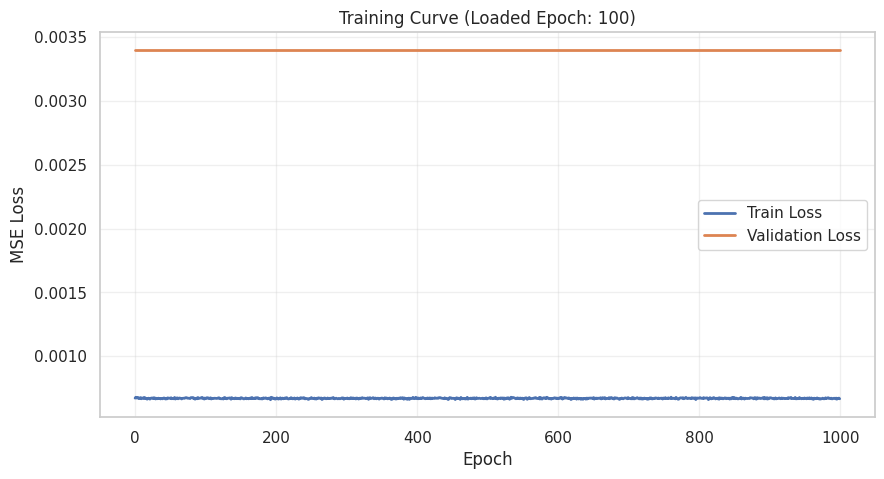


--- Sample Predictions (Val Set) ---
GT Mass    Pred Mass  | GT Mu      Pred Mu   
---------------------------------------------
1.1771     1.2854     | 0.3163     0.3405
2.3527     2.3347     | 0.4052     0.4048
0.9555     1.0350     | 0.2658     0.3106
2.2101     2.2376     | 0.2521     0.2752
0.5081     0.5102     | 0.2812     0.3592


In [66]:
import torch
import matplotlib.pyplot as plt
import os

# ==========================================
# 4. LOAD CHECKPOINT & VISUALIZE
# ==========================================

# --- CONFIGURATION: WHICH MODEL TO LOAD? ---
# Set this to the epoch number you want to load (e.g., 50000)
# Or set to None to use the model currently in memory (if you just finished training)
CHECKPOINT_DIR = f"checkpoints/{CRITERION_TYPE}_{LOSS_TYPE}"
LOAD_EPOCH = 100
CRITERION_TYPE = "mse"
LOSS_TYPE = "data"

# 1. Initialize Model Structure (Must match training config)
#    (We re-initialize to ensure we are testing a clean state, or if running this later)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PhysicsTransformerEstimator(
    input_dim=2, 
    d_model=64, 
    nhead=4, 
    num_encoder_layers=2, 
    seq_len=20 # Make sure this matches your data prep
).to(device)

# 2. Load Weights
if LOAD_EPOCH is not None:
    load_path = f"{CHECKPOINT_DIR}/transformer_epoch{LOAD_EPOCH}.pth"
    
    if os.path.exists(load_path):
        print(f"🔄 Loading model from: {load_path}")
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict)
        print("✅ Model weights loaded successfully!")
    else:
        print(f"❌ Error: Checkpoint not found at {load_path}")
        print("   Using random initialization or current model state.")
else:
    print("ℹ️ Using current model state (no file loaded).")

# 3. VISUALIZATION
print("\n--- Running Evaluation ---")

# A. Loss Curve (Only available if you just trained, otherwise skip)
if 'train_losses' in locals() and len(train_losses) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title(f'Training Curve (Loaded Epoch: {LOAD_EPOCH})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("ℹ️ No training loss history found in memory (skipped plot).")

# B. Prediction Check (First 5 samples of Val Set)
model.eval()
with torch.no_grad():
    # Get a batch from validation loader
    try:
        sample_acc, sample_vel, sample_y = next(iter(val_loader))
    except NameError:
        print("❌ Error: 'val_loader' is not defined. Please run Data Preparation first.")
        sample_acc = None

    if sample_acc is not None:
        sample_acc, sample_vel = sample_acc.to(device), sample_vel.to(device)
        preds = model(sample_acc, sample_vel).cpu()
        
        print("\n--- Sample Predictions (Val Set) ---")
        print(f"{'GT Mass':<10} {'Pred Mass':<10} | {'GT Mu':<10} {'Pred Mu':<10}")
        print("-" * 45)
        for i in range(5):
            print(f"{sample_y[i,0]:.4f}     {preds[i,0]:.4f}     | {sample_y[i,1]:.4f}     {preds[i,1]:.4f}")


STARTING COMPREHENSIVE PHYSICS-DRIVEN EVALUATION
1. Calculating Performance Metrics...
------------------------------
Mass MAE [kg]     : 0.0620
Mass R2           : 0.9926
Mu MAE            : 0.0232
Mu R2             : 0.9007
------------------------------
2. Generating Statistical Dashboard...


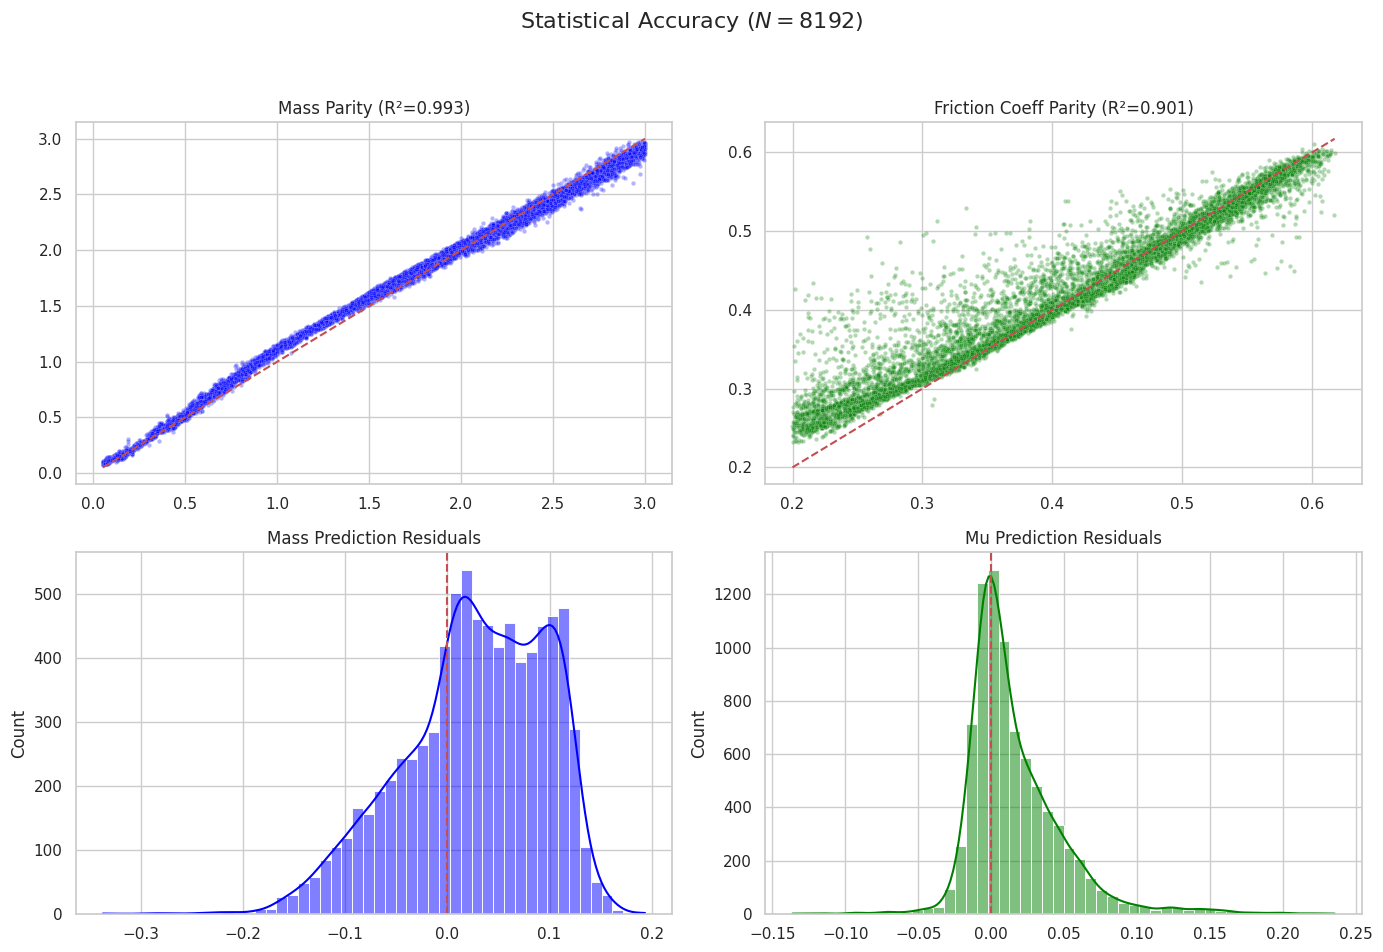

3. Visualizing Newtonian Decoupling (Sampled Force Profiles)...


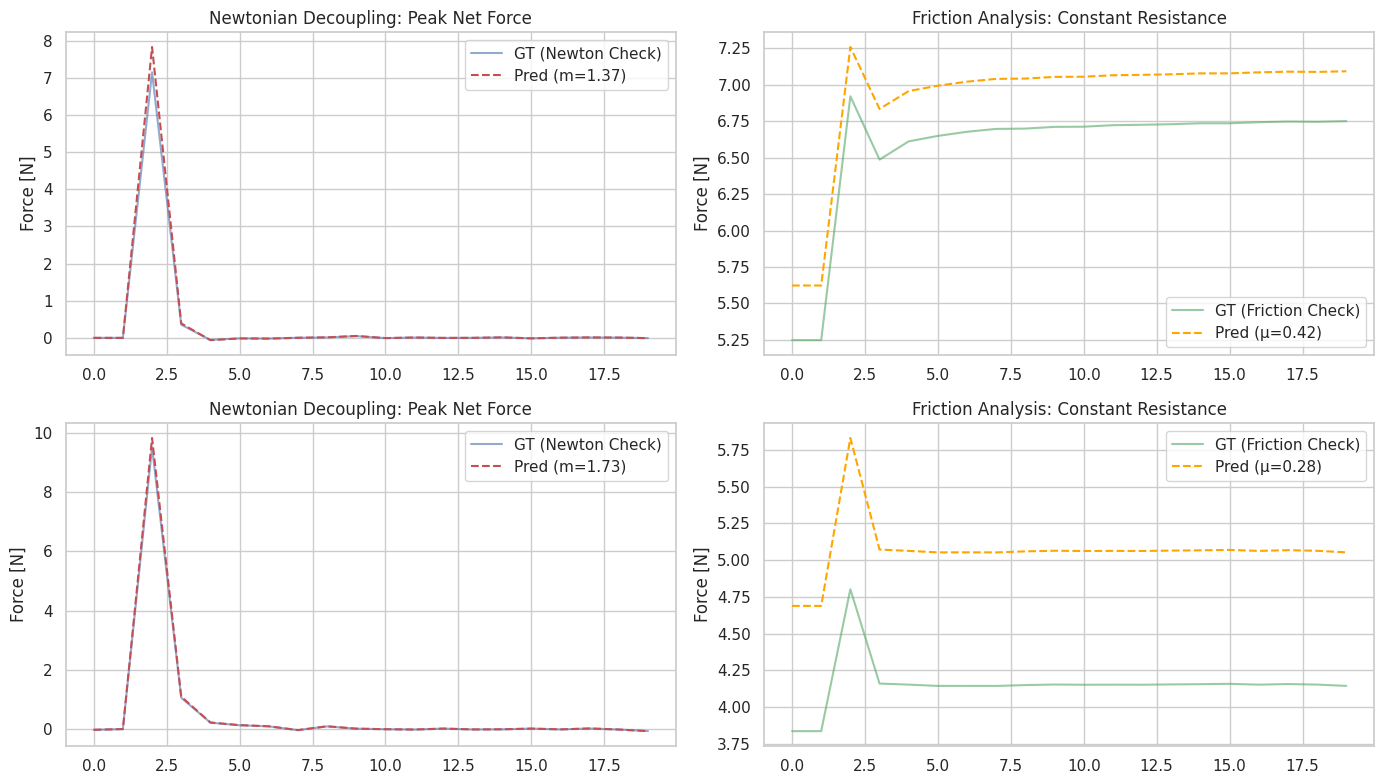

4. Analyzing Attention Spotlights (The Transformer Spotlight)...


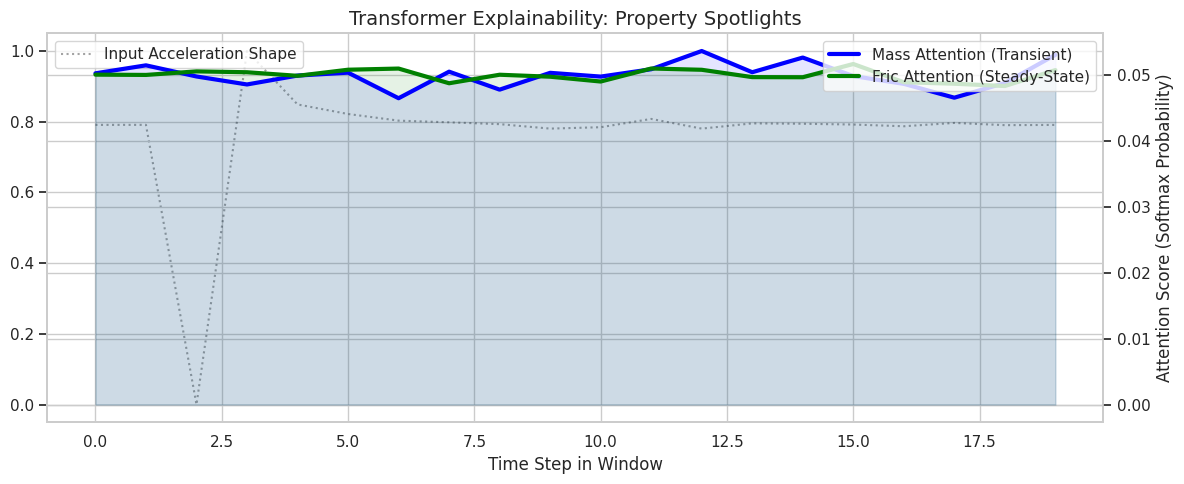

✅ COMPREHENSIVE PHYSICS EVALUATION COMPLETE.


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# MASTER EVALUATION CELL
# ==========================================
if 'model' in locals() and 'val_loader' in locals():
    print("\n" + "="*50)
    print("STARTING COMPREHENSIVE PHYSICS-DRIVEN EVALUATION")
    print("="*50)
    
    # ---------------------------------------------------------
    # PART 1: GLOBAL METRICS (Standard Estimation Accuracy)
    # ---------------------------------------------------------
    print("1. Calculating Performance Metrics...")
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for b_acc, b_vel, b_y in val_loader:
            b_acc, b_vel = b_acc.to(device), b_vel.to(device)
            preds = model(b_acc, b_vel)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(b_y.numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    mass_gt, mass_pred = all_targets[:, 0], all_preds[:, 0]
    mu_gt, mu_pred = all_targets[:, 1], all_preds[:, 1]

    metrics = {
        "Mass MAE [kg]": mean_absolute_error(mass_gt, mass_pred),
        "Mass R2": r2_score(mass_gt, mass_pred),
        "Mu MAE": mean_absolute_error(mu_gt, mu_pred),
        "Mu R2": r2_score(mu_gt, mu_pred),
    }

    print("-" * 30)
    for k, v in metrics.items():
        print(f"{k:<18}: {v:.4f}")
    print("-" * 30)

    # ---------------------------------------------------------
    # PART 2: STATISTICAL DASHBOARD (Estimation Quality)
    # ---------------------------------------------------------
    print("2. Generating Statistical Dashboard...")
    sns.set_style("whitegrid")
    fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig1.suptitle(f"Statistical Accuracy ($N={len(mass_gt)}$)", fontsize=16)

    # Parity Plots
    sns.scatterplot(x=mass_gt, y=mass_pred, ax=axes[0,0], alpha=0.3, color='blue', s=10)
    axes[0,0].plot([mass_gt.min(), mass_gt.max()], [mass_gt.min(), mass_gt.max()], 'r--')
    axes[0,0].set_title(f"Mass Parity (R²={metrics['Mass R2']:.3f})")
    
    sns.scatterplot(x=mu_gt, y=mu_pred, ax=axes[0,1], alpha=0.3, color='green', s=10)
    axes[0,1].plot([mu_gt.min(), mu_gt.max()], [mu_gt.min(), mu_gt.max()], 'r--')
    axes[0,1].set_title(f"Friction Coeff Parity (R²={metrics['Mu R2']:.3f})")

    # Residuals
    sns.histplot(mass_pred - mass_gt, kde=True, ax=axes[1,0], color='blue', bins=50)
    axes[1,0].set_title("Mass Prediction Residuals")
    axes[1,0].axvline(0, color='r', linestyle='--')
    
    sns.histplot(mu_pred - mu_gt, kde=True, ax=axes[1,1], color='green', bins=50)
    axes[1,1].set_title("Mu Prediction Residuals")
    axes[1,1].axvline(0, color='r', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ---------------------------------------------------------
    # PART 3: PHYSICS RECONSTRUCTION (Newtonian Decoupling)
    # ---------------------------------------------------------
    print("3. Visualizing Newtonian Decoupling (Sampled Force Profiles)...")
    num_samples = 2
    indices = np.random.randint(0, len(df), size=num_samples)
    AXIS_MOTION, AXIS_VERTICAL, G = 3, 5, 9.81
    
    fig2, axes2 = plt.subplots(num_samples, 2, figsize=(14, 4 * num_samples))
    
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))

    for i, idx in enumerate(indices):
        row = df.iloc[idx]
        x_acc_np = row[acc_cols].values.astype(np.float32).reshape(1, 20, 1)
        x_vel_np = row[vel_cols].values.astype(np.float32).reshape(1, 20, 1)
        
        with torch.no_grad():
            preds = model(torch.tensor(x_acc_np).to(device), torch.tensor(x_vel_np).to(device)).cpu().numpy()[0]
        
        rhs_acc = get_sequence_data(row, "pinn_RHS_acc")[int(row['start_t']):int(row['start_t'])+20]
        rob_wrench = get_sequence_data(row, "pinn_robot_wrench")[int(row['start_t']):int(row['start_t'])+20]
        time_steps = np.arange(20)

        # Plot 1: The Mass Signature (Transient Net Force)
        ax = axes2[i, 0]
        ax.plot(time_steps, row['gt_mass'] * rhs_acc[:, AXIS_MOTION], 'b-', alpha=0.6, label='GT (Newton Check)')
        ax.plot(time_steps, preds[0] * rhs_acc[:, AXIS_MOTION], 'r--', label=f'Pred (m={preds[0]:.2f})')
        ax.set_title(f"Newtonian Decoupling: Peak Net Force")
        ax.set_ylabel("Force [N]")
        ax.legend()
        
        # Plot 2: The Friction Signature (Steady-State Resistance)
        ax = axes2[i, 1]
        norm_force_gt = (row['gt_mass'] * G) - rob_wrench[:, AXIS_VERTICAL]
        norm_force_pred = (preds[0] * G) - rob_wrench[:, AXIS_VERTICAL]
        ax.plot(time_steps, row['gt_mu'] * norm_force_gt, 'g-', alpha=0.6, label='GT (Friction Check)')
        ax.plot(time_steps, preds[1] * norm_force_pred, 'orange', linestyle='--', label=f'Pred (μ={preds[1]:.2f})')
        ax.set_title(f"Friction Analysis: Constant Resistance")
        ax.set_ylabel("Force [N]")
        ax.legend()
        
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # PART 4: ATTENTION SPOTLIGHT ANALYSIS (Explainability)
    # ---------------------------------------------------------
    print("4. Analyzing Attention Spotlights (The Transformer Spotlight)...")
    
    activations = {}
    def get_hook(name):
        def hook(model, input, output):
            if isinstance(output, tuple): activations[name] = output[1].detach().cpu()
            else: activations[name] = output.detach().cpu()
        return hook

    hooks = [
        model.mass_attn.register_forward_hook(get_hook('mass_attn')),
        model.fric_attn.register_forward_hook(get_hook('fric_attn'))
    ]

    # Select random test sample
    row = df.iloc[np.random.randint(0, len(df))]
    x_acc = torch.tensor(row[acc_cols].values.astype(np.float32).reshape(1, 20, 1)).to(device)
    x_vel = torch.tensor(row[vel_cols].values.astype(np.float32).reshape(1, 20, 1)).to(device)
    
    with torch.no_grad(): _ = model(x_acc, x_vel)
    for h in hooks: h.remove()

    fig3, ax_att = plt.subplots(figsize=(12, 5))
    ax_att.set_title(f"Transformer Explainability: Property Spotlights", fontsize=14)
    
    # Scale kinematics for visibility
    t = range(20)
    acc_norm = row[acc_cols].values.astype(np.float32)
    acc_norm = (acc_norm - acc_norm.min()) / (acc_norm.max() - acc_norm.min() + 1e-6)
    
    ax_att.plot(t, acc_norm, 'k:', alpha=0.4, label='Input Acceleration Shape')
    
    # Dual axis for Attention probabilities
    ax_p = ax_att.twinx()
    mass_weights = activations['mass_attn'].squeeze().numpy()
    fric_weights = activations['fric_attn'].squeeze().numpy()
    
    ax_p.plot(t, mass_weights, 'blue', lw=3, label='Mass Attention (Transient)')
    ax_p.fill_between(t, 0, mass_weights, color='blue', alpha=0.1)
    
    ax_p.plot(t, fric_weights, 'green', lw=3, label='Fric Attention (Steady-State)')
    ax_p.fill_between(t, 0, fric_weights, color='green', alpha=0.1)
    
    ax_p.set_ylabel("Attention Score (Softmax Probability)")
    ax_att.set_xlabel("Time Step in Window")
    ax_att.legend(loc='upper left')
    ax_p.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    print("✅ COMPREHENSIVE PHYSICS EVALUATION COMPLETE.")

else:
    print("❌ Model or Loader missing. Please run the training script.")

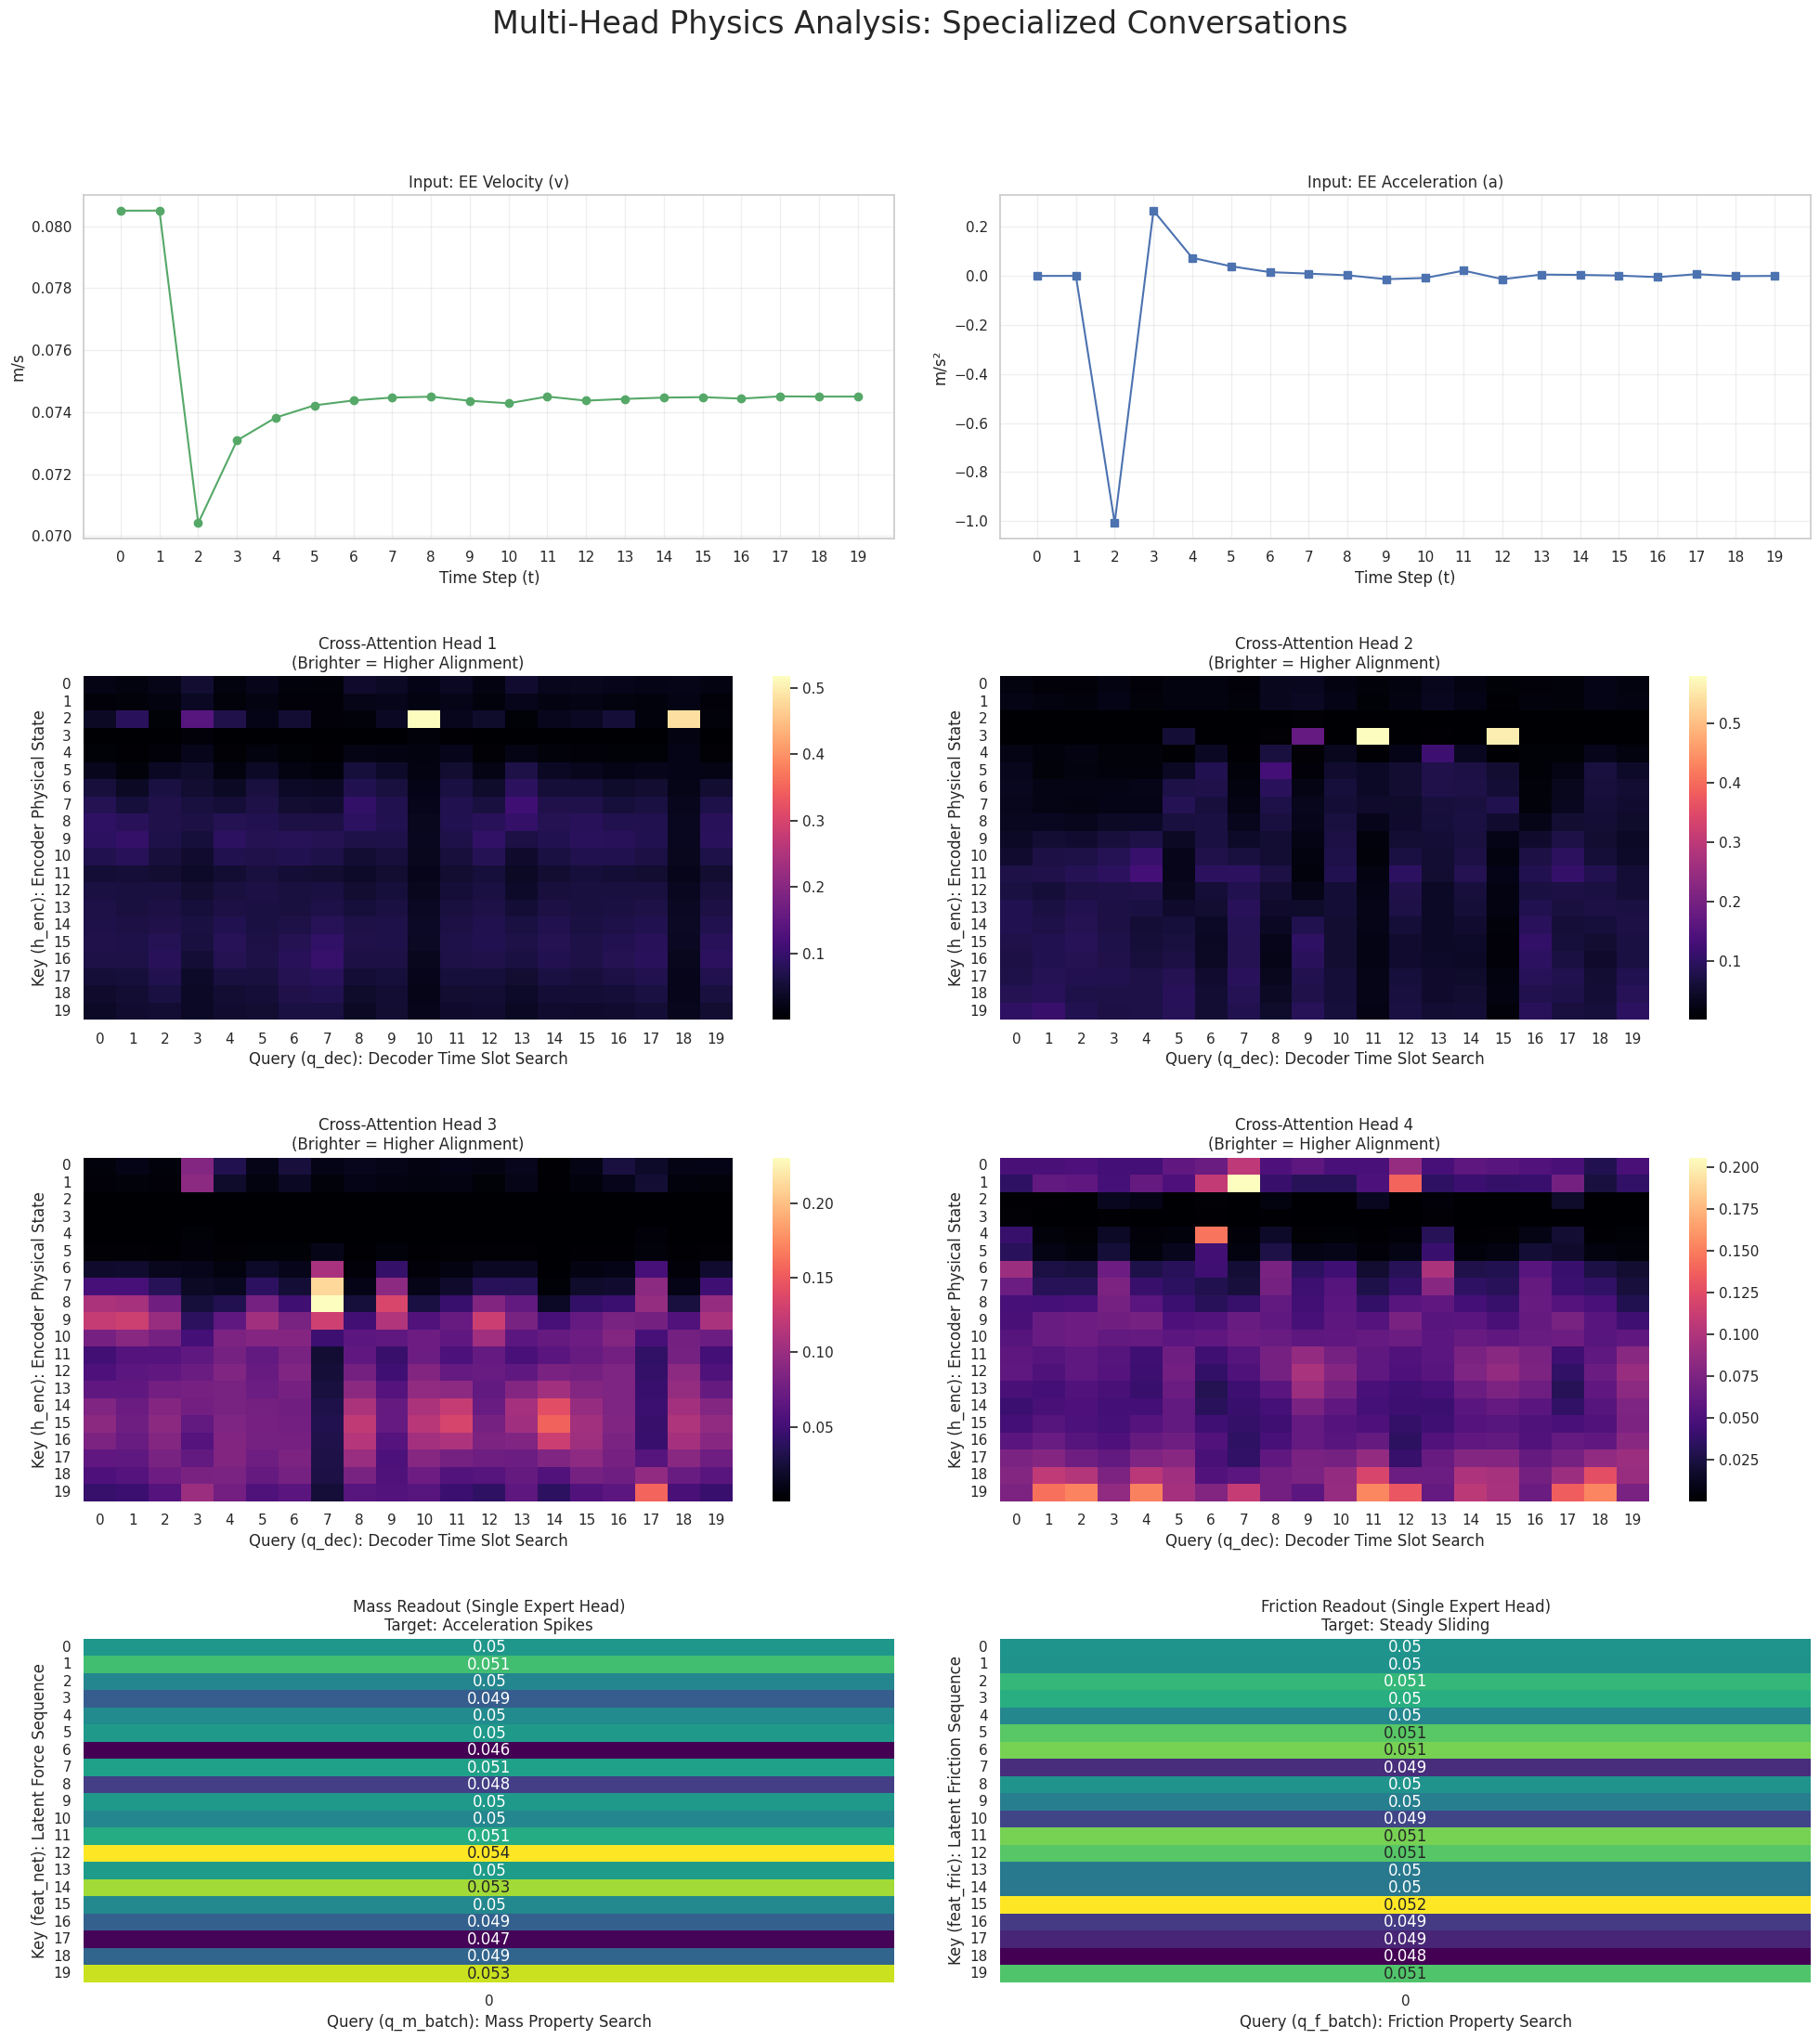

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# ============================================================
# 4-HEAD CROSS-ATTENTION & SPOTLIGHT ANALYSIS
# ============================================================
model.eval()
attn_maps = {}

def get_attn_hook(name):
    def hook(module, input, output):
        # MultiheadAttention returns (output, weights)
        if isinstance(output, tuple) and len(output) > 1:
            attn_maps[name] = output[1].detach().cpu().numpy()
    return hook

# Register Hooks
hooks = [
    model.cross_attn.register_forward_hook(get_attn_hook('dec_enc')),  
    model.mass_attn.register_forward_hook(get_attn_hook('mass_net')),  
    model.fric_attn.register_forward_hook(get_attn_hook('fric_fric'))  
]

# Run Inference
with torch.no_grad():
    input_acc = x_acc.detach().clone().to(device) if torch.is_tensor(x_acc) else torch.from_numpy(x_acc).to(device)
    input_vel = x_vel.detach().clone().to(device) if torch.is_tensor(x_vel) else torch.from_numpy(x_vel).to(device)
    
    # Ensure average_attn_weights=False is set in your model's forward pass 
    # to visualize all 4 heads separately.
    _ = model(input_acc, input_vel)

for h in hooks: h.remove()

# ------------------------------------------------------------
# PLOTTING 4 HEADS + SPOTLIGHTS
# ------------------------------------------------------------
fig = plt.figure(figsize=(24, 25))
gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

t_steps = np.arange(20) # Time steps 0 ~ 19
plot_vel = input_vel.detach().cpu().numpy().flatten()
plot_acc = input_acc.detach().cpu().numpy().flatten()

# Row 1: Kinematics with explicit t=0~19 labeling
ax_v = fig.add_subplot(gs[0, :2])
ax_v.plot(t_steps, plot_vel, 'g-o', label='EE Velocity')
ax_v.set_title("Input: EE Velocity (v)")
ax_v.set_xticks(t_steps)
ax_v.set_xlabel("Time Step (t)")
ax_v.set_ylabel("m/s")
ax_v.grid(True, alpha=0.3)

ax_a = fig.add_subplot(gs[0, 2:])
ax_a.plot(t_steps, plot_acc, 'b-s', label='EE Acceleration')
ax_a.set_title("Input: EE Acceleration (a)")
ax_a.set_xticks(t_steps)
ax_a.set_xlabel("Time Step (t)")
ax_a.set_ylabel("m/s²")
ax_a.grid(True, alpha=0.3)

# Row 2 & 3: The 4 Individual Heads of Cross-Attention
cross_weights = attn_maps['dec_enc'][0] # Shape [4, 20, 20]

for h_idx in range(4):
    ax = fig.add_subplot(gs[1 if h_idx < 2 else 2, (h_idx % 2) * 2 : ((h_idx % 2) * 2) + 2])
    # T is used to match Query as Column and Key as Row per your requirement
    sns.heatmap(cross_weights[h_idx].T, ax=ax, cmap="magma", cbar=True)
    ax.set_title(f"Cross-Attention Head {h_idx+1}\n(Brighter = Higher Alignment)")
    ax.set_xlabel("Query (q_dec): Decoder Time Slot Search")
    ax.set_ylabel("Key (h_enc): Encoder Physical State")

# Row 4: Global Readout Spotlights (1 head each)
# Mass Readout
ax_m = fig.add_subplot(gs[3, :2])
sns.heatmap(attn_maps['mass_net'][0].T, ax=ax_m, cmap="viridis", annot=True, cbar=False)
ax_m.set_title("Mass Readout (Single Expert Head)\nTarget: Acceleration Spikes")
ax_m.set_xlabel("Query (q_m_batch): Mass Property Search")
ax_m.set_ylabel("Key (feat_net): Latent Force Sequence")

# Friction Readout
ax_f = fig.add_subplot(gs[3, 2:])
sns.heatmap(attn_maps['fric_fric'][0].T, ax=ax_f, cmap="viridis", annot=True, cbar=False)
ax_f.set_title("Friction Readout (Single Expert Head)\nTarget: Steady Sliding")
ax_f.set_xlabel("Query (q_f_batch): Friction Property Search")
ax_f.set_ylabel("Key (feat_fric): Latent Friction Sequence")

plt.suptitle("Multi-Head Physics Analysis: Specialized Conversations", fontsize=24, y=0.96)
plt.show()

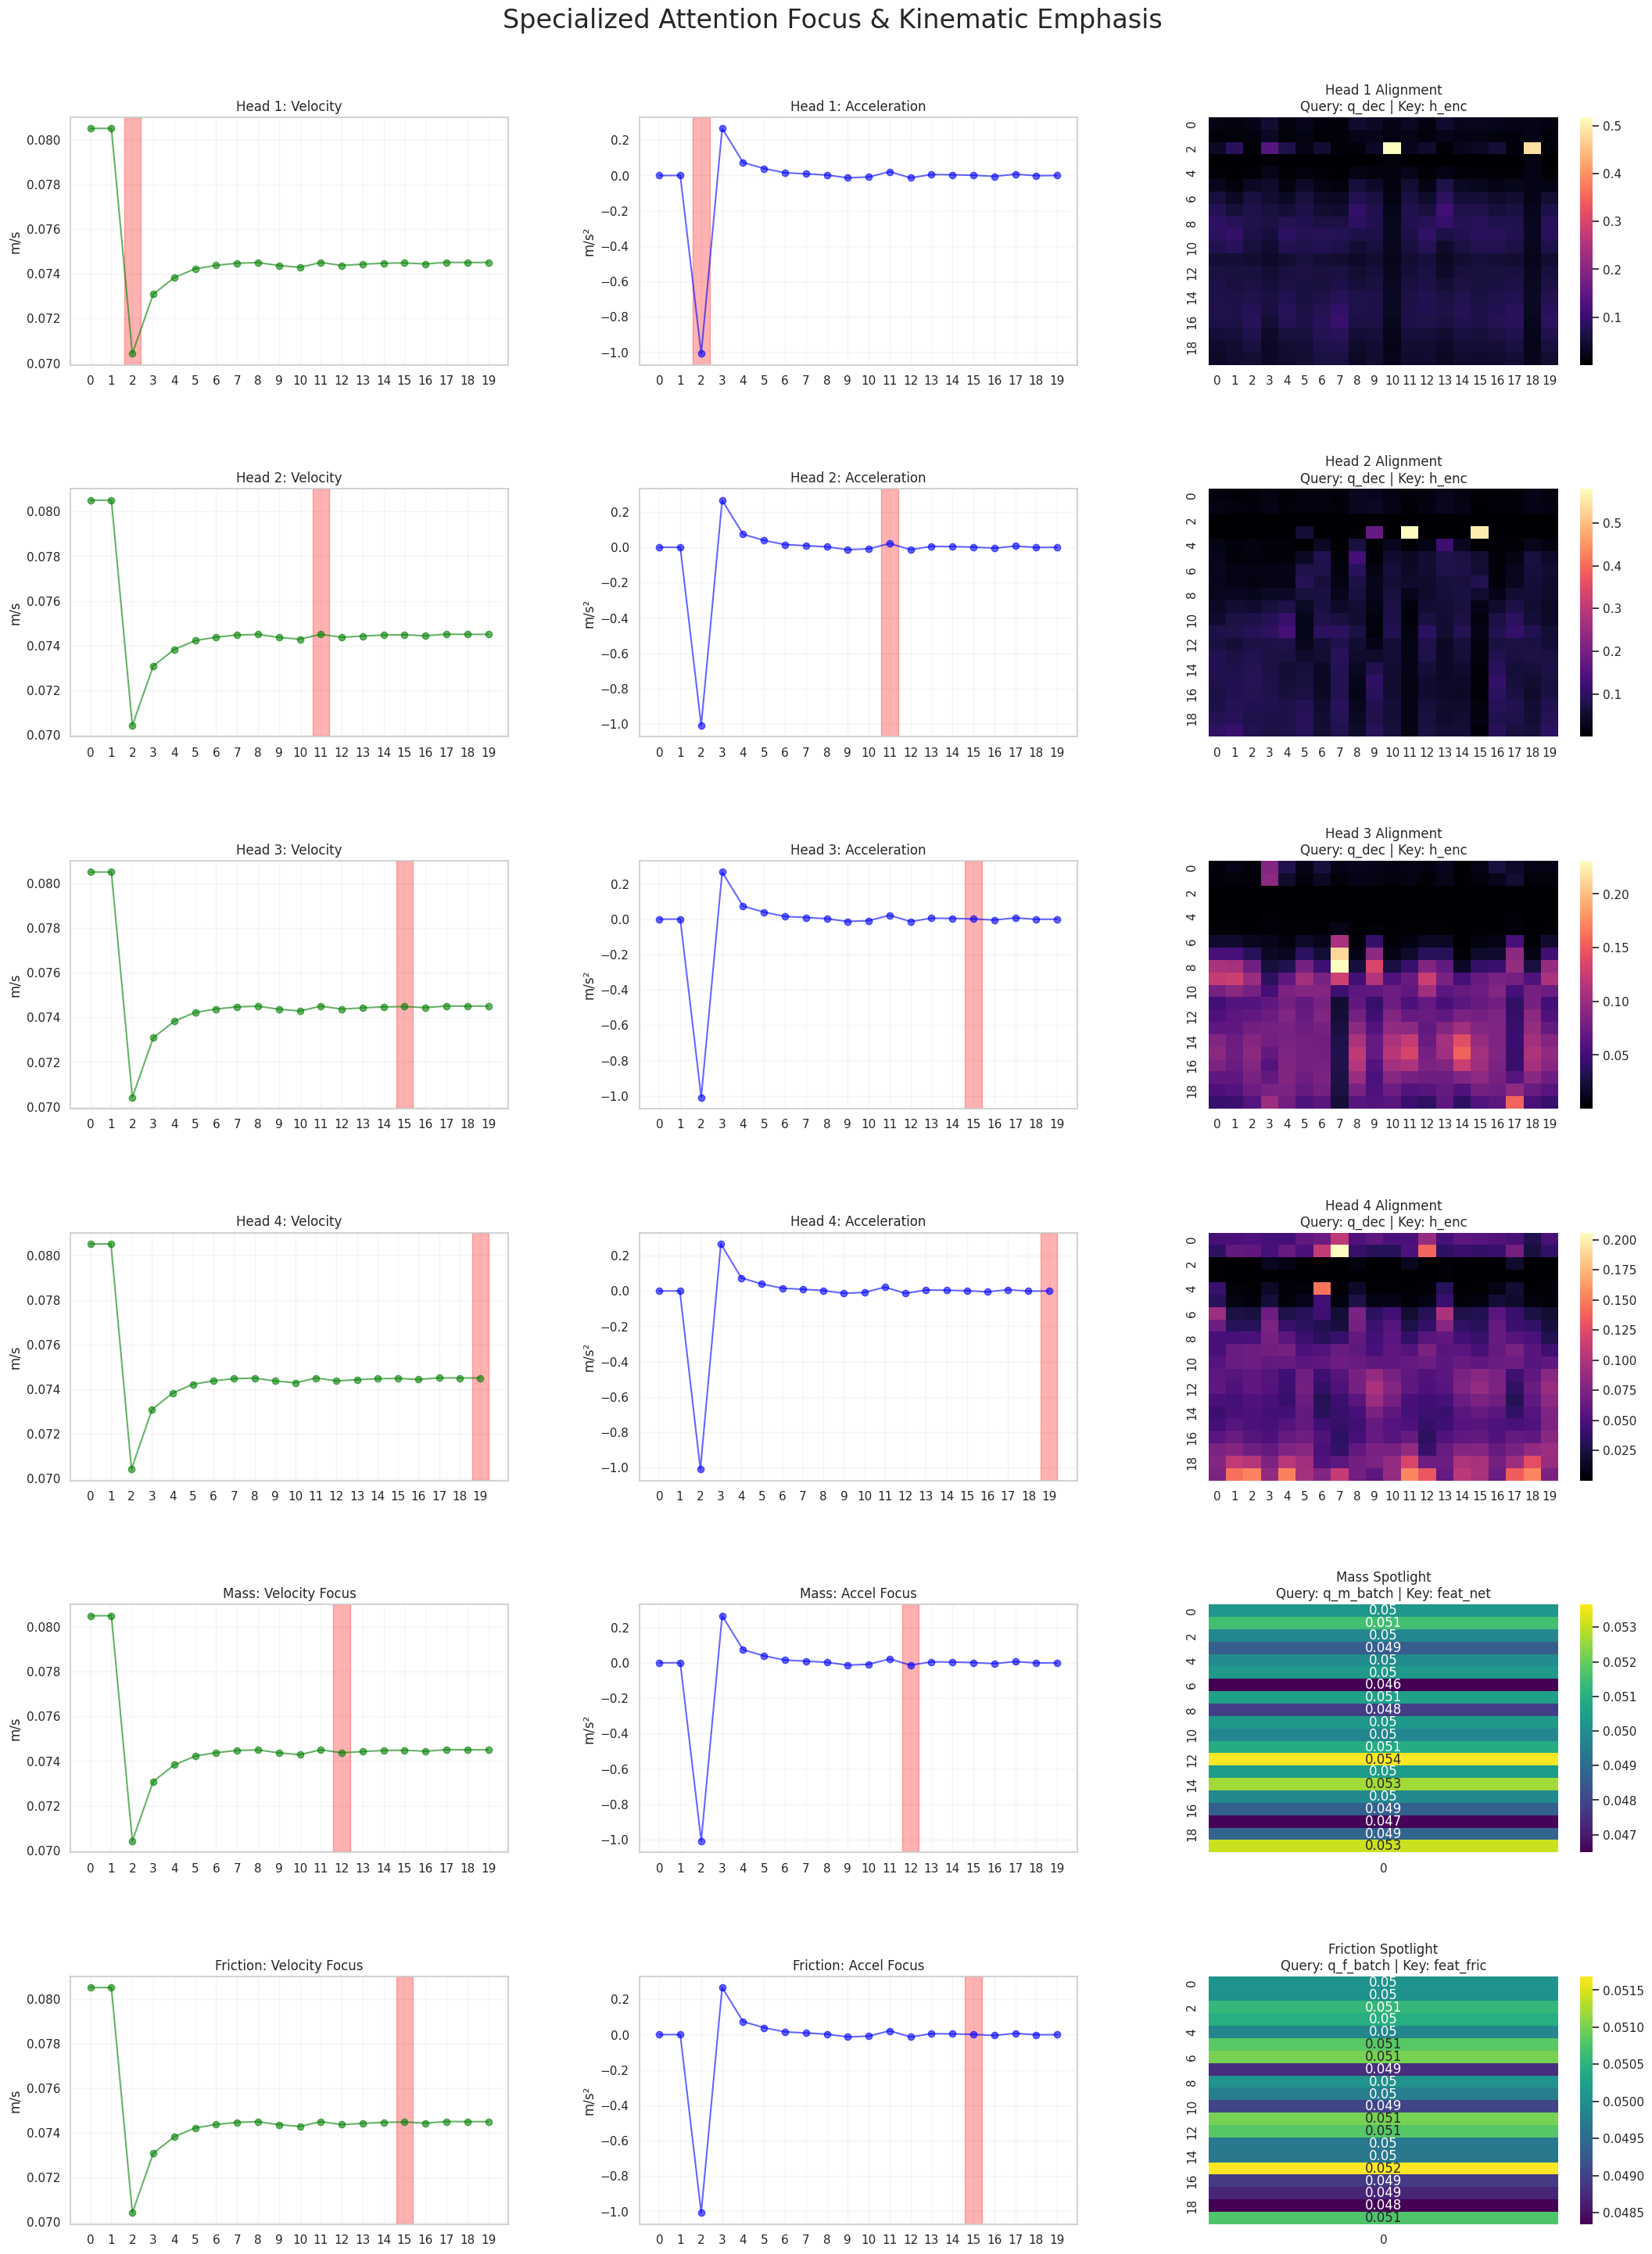

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# ============================================================
# 4-HEAD CROSS-ATTENTION & SPOTLIGHT WITH KINEMATIC EMPHASIS
# ============================================================
model.eval()
attn_maps = {}

def get_attn_hook(name):
    def hook(module, input, output):
        if isinstance(output, tuple) and len(output) > 1:
            attn_maps[name] = output[1].detach().cpu().numpy()
    return hook

# Register Hooks
hooks = [
    model.cross_attn.register_forward_hook(get_attn_hook('dec_enc')),  
    model.mass_attn.register_forward_hook(get_attn_hook('mass_net')),  
    model.fric_attn.register_forward_hook(get_attn_hook('fric_fric'))  
]

# Run Inference
with torch.no_grad():
    input_acc = x_acc.detach().clone().to(device) if torch.is_tensor(x_acc) else torch.from_numpy(x_acc).to(device)
    input_vel = x_vel.detach().clone().to(device) if torch.is_tensor(x_vel) else torch.from_numpy(x_vel).to(device)
    _ = model(input_acc, input_vel)

for h in hooks: h.remove()

# Data Preparation
t_steps = np.arange(20)
plot_vel = input_vel.detach().cpu().numpy().flatten()
plot_acc = input_acc.detach().cpu().numpy().flatten()

def plot_emphasized_kinematics(ax, data, title, weights, color, ylabel):
    """Plots kinematics and emphasizes indices with max attention weights."""
    ax.plot(t_steps, data, color=color, marker='o', alpha=0.6, label=title)
    # Find all indices with the maximum attention weight
    max_val = np.max(weights)
    max_indices = np.where(weights == max_val)[0]
    
    for idx in max_indices:
        ax.axvspan(idx - 0.4, idx + 0.4, color='red', alpha=0.3, label='Max Attention' if idx == max_indices[0] else "")
    
    ax.set_title(title)
    ax.set_xticks(t_steps)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)

# ------------------------------------------------------------
# PLOTTING GRID
# ------------------------------------------------------------
# Layout: 6 Rows (Head 1, Head 2, Head 3, Head 4, Mass, Friction)
# Each row has: Velocity (Left), Acceleration (Center), Attention Map (Right)
fig = plt.figure(figsize=(26, 35))
gs = fig.add_gridspec(6, 3, hspace=0.5, wspace=0.3)

# --- Rows 0 to 3: Cross-Attention Heads 1-4 ---
cross_weights = attn_maps['dec_enc'][0] # Shape [4, 20, 20]
for h_idx in range(4):
    h_weights = cross_weights[h_idx]
    # For emphasis, we take the mean weight across all decoder queries for that head
    head_importance = np.mean(h_weights, axis=0) 
    
    ax_v = fig.add_subplot(gs[h_idx, 0])
    plot_emphasized_kinematics(ax_v, plot_vel, f"Head {h_idx+1}: Velocity", head_importance, 'green', "m/s")
    
    ax_a = fig.add_subplot(gs[h_idx, 1])
    plot_emphasized_kinematics(ax_a, plot_acc, f"Head {h_idx+1}: Acceleration", head_importance, 'blue', "m/s²")
    
    ax_m = fig.add_subplot(gs[h_idx, 2])
    sns.heatmap(h_weights.T, ax=ax_m, cmap="magma", cbar=True)
    ax_m.set_title(f"Head {h_idx+1} Alignment\nQuery: q_dec | Key: h_enc")

# --- Row 4: Mass Readout ---
mass_weights = attn_maps['mass_net'][0].flatten()
ax_mv = fig.add_subplot(gs[4, 0])
plot_emphasized_kinematics(ax_mv, plot_vel, "Mass: Velocity Focus", mass_weights, 'green', "m/s")
ax_ma = fig.add_subplot(gs[4, 1])
plot_emphasized_kinematics(ax_ma, plot_acc, "Mass: Accel Focus", mass_weights, 'blue', "m/s²")
ax_mm = fig.add_subplot(gs[4, 2])
sns.heatmap(attn_maps['mass_net'][0].T, ax=ax_mm, cmap="viridis", annot=True)
ax_mm.set_title("Mass Spotlight\nQuery: q_m_batch | Key: feat_net")

# --- Row 5: Friction Readout ---
fric_weights = attn_maps['fric_fric'][0].flatten()
ax_fv = fig.add_subplot(gs[5, 0])
plot_emphasized_kinematics(ax_fv, plot_vel, "Friction: Velocity Focus", fric_weights, 'green', "m/s")
ax_fa = fig.add_subplot(gs[5, 1])
plot_emphasized_kinematics(ax_fa, plot_acc, "Friction: Accel Focus", fric_weights, 'blue', "m/s²")
ax_ff = fig.add_subplot(gs[5, 2])
sns.heatmap(attn_maps['fric_fric'][0].T, ax=ax_ff, cmap="viridis", annot=True)
ax_ff.set_title("Friction Spotlight\nQuery: q_f_batch | Key: feat_fric")

plt.suptitle("Specialized Attention Focus & Kinematic Emphasis", fontsize=24, y=0.92)
plt.show()

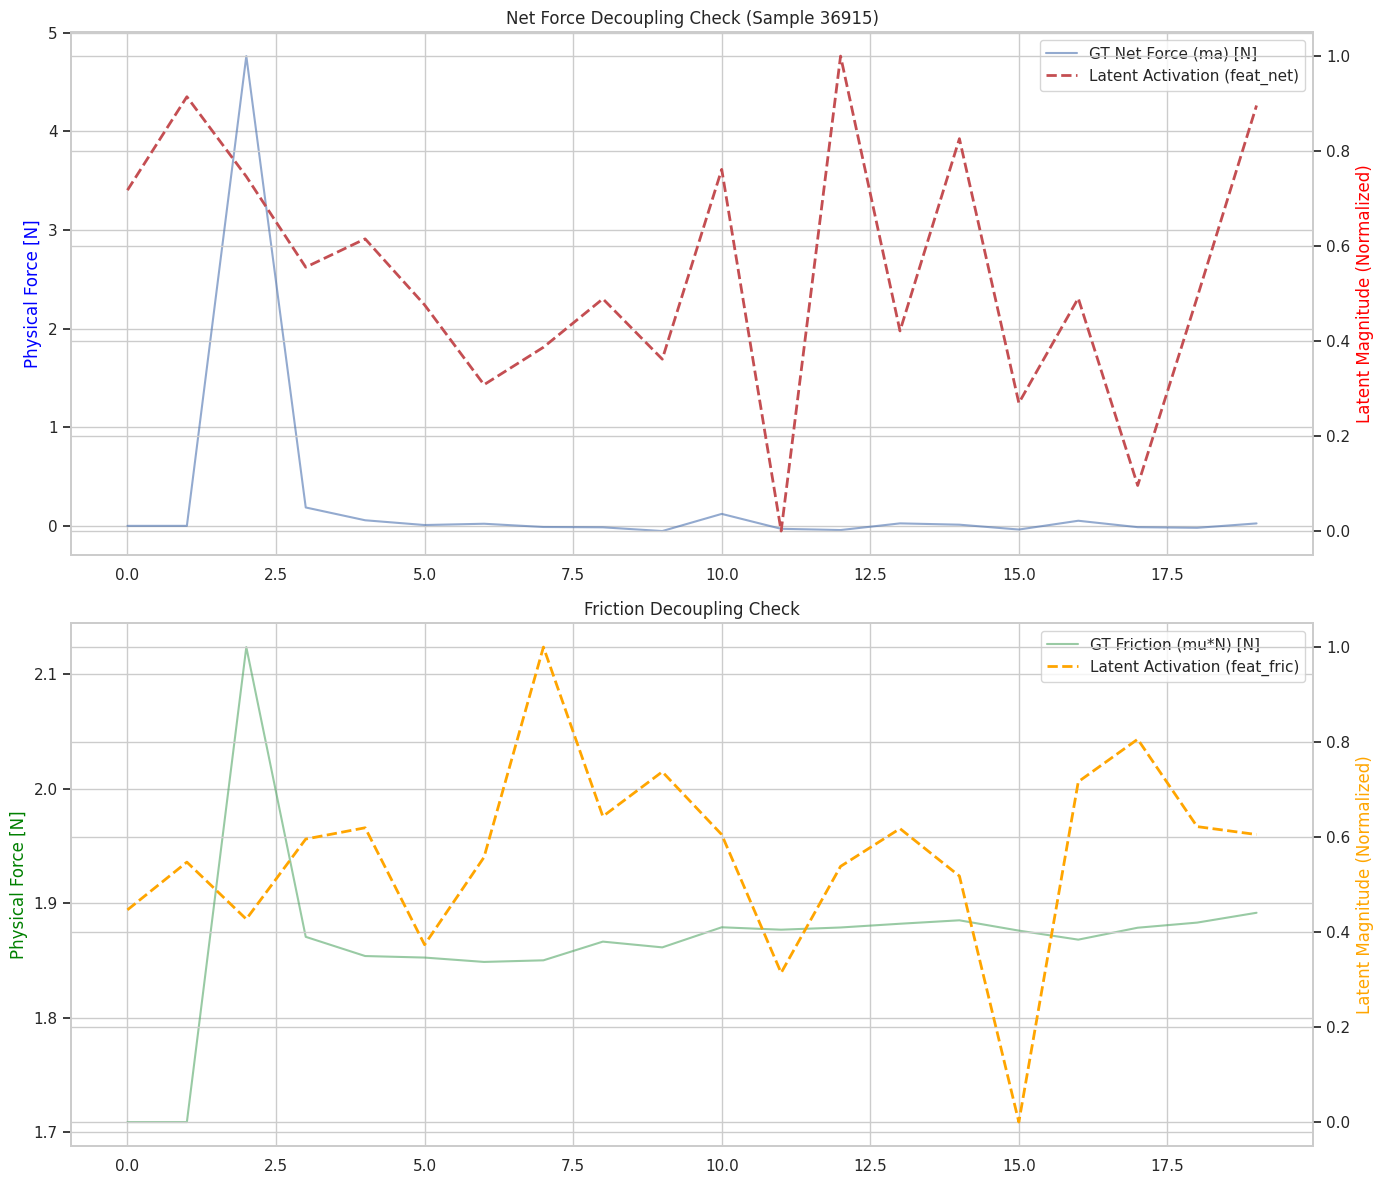

In [74]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ============================================================
# PHYSICS VS. LATENT RECONSTRUCTION COMPARISON
# ============================================================
model.eval()
latent_data = {}

def get_latent_hook(name):
    def hook(module, input, output):
        latent_data[name] = output.detach().cpu().numpy()
    return hook

# 1. Register hooks for latent force sequences
hooks = [
    model.net_force_mlp.register_forward_hook(get_latent_hook('feat_net')),
    model.fric_force_mlp.register_forward_hook(get_latent_hook('feat_fric'))
]

# 2. Run inference on the current sample (using input_acc/input_vel from previous cell)
with torch.no_grad():
    _ = model(input_acc, input_vel)

for h in hooks: h.remove()

# 3. Calculate Ground Truth (GT) Forces from Dataframe
# Assuming 'row' is the current sample being evaluated
AXIS_MOTION, AXIS_VERTICAL, G = 3, 5, 9.81
start_t = int(row['start_t'])
end_t = start_t + 20

# Get sequences for the 20-step window
rhs_acc = get_sequence_data(row, "pinn_RHS_acc")[start_t:end_t]
rob_wrench = get_sequence_data(row, "pinn_robot_wrench")[start_t:end_t]

# Newtonian GT Calculation
gt_net_force = row['gt_mass'] * rhs_acc[:, AXIS_MOTION]
gt_normal_force = (row['gt_mass'] * G) - rob_wrench[:, AXIS_VERTICAL]
gt_fric_force = row['gt_mu'] * gt_normal_force

# 4. Normalize Latent Trends for visual comparison
def norm_latent(arr): 
    res = np.mean(arr[0], axis=-1)
    return (res - res.min()) / (res.max() - res.min() + 1e-6)

net_latent_norm = norm_latent(latent_data['feat_net'])
fric_latent_norm = norm_latent(latent_data['feat_fric'])
t_steps = np.arange(20)

# 5. Plotting Comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# --- Plot 1: Net Force (ma) Comparison ---
ax1_twin = axes[0].twinx()
lns1 = axes[0].plot(t_steps, gt_net_force, 'b-', alpha=0.6, label='GT Net Force (ma) [N]')
lns2 = ax1_twin.plot(t_steps, net_latent_norm, 'r--', lw=2, label='Latent Activation (feat_net)')
axes[0].set_title(f"Net Force Decoupling Check (Sample {idx})")
axes[0].set_ylabel("Physical Force [N]", color='blue')
ax1_twin.set_ylabel("Latent Magnitude (Normalized)", color='red')

# --- Plot 2: Friction (mu*N) Comparison ---
ax2_twin = axes[1].twinx()
lns3 = axes[1].plot(t_steps, gt_fric_force, 'g-', alpha=0.6, label='GT Friction (mu*N) [N]')
lns4 = ax2_twin.plot(t_steps, fric_latent_norm, 'orange', linestyle='--', lw=2, label='Latent Activation (feat_fric)')
axes[1].set_title("Friction Decoupling Check")
axes[1].set_ylabel("Physical Force [N]", color='green')
ax2_twin.set_ylabel("Latent Magnitude (Normalized)", color='orange')

# Combine legends
all_lns1 = lns1 + lns2
labs1 = [l.get_label() for l in all_lns1]
axes[0].legend(all_lns1, labs1, loc='upper right')

all_lns2 = lns3 + lns4
labs2 = [l.get_label() for l in all_lns2]
axes[1].legend(all_lns2, labs2, loc='upper right')

plt.tight_layout()
plt.show()